In [1]:
import os
import pandas as pd
import numpy as np

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import pearsonr,spearmanr
import warnings
warnings.filterwarnings("ignore")#忽略警告

import datetime
from collections import Counter
from scipy import stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# from calendar import day_abbr, month_abbr, mdays
# import holidays
# from fbprophet import Prophet
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2, mean_absolute_percentage_error as MAPE
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn import svm
import joblib

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

from pathlib import Path
from warnings import simplefilter

In [2]:
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [3]:
df=pd.read_csv('./data/preprocessed/data.csv')
df['Date']=pd.to_datetime(df['Date'].astype('str'))
df.set_index('Date',drop=True,inplace=True)

# x = df.iloc[:,1:]  # features
# x_train=x.loc[:'2022-02-28',:]
# x_test=x.loc['2022-03-01':,:]
# y = df.loc[:, ['Price']]  # target
# y_train=y.loc[:'2022-02-28',:]
# y_test=y.loc['2022-03-01':,:]

# # Pre-process data
# scaler = MinMaxScaler() 
# x_train1 = scaler.fit_transform(x_train)
# x_test1 = scaler.transform(x_test)
# scaler = StandardScaler()
# x_train2 = scaler.fit_transform(x_train)
# x_test2 = scaler.transform(x_test)

In [4]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

In [5]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [6]:
def forecast(n,a,m,s):  
    # YOUR CODE HERE: Make 4 lag features
    # X = make_lags(df, lags=1).dropna()
    if n==0:
        X = pd.DataFrame(df.iloc[:,1:])    
    elif n>=0:    
        if a=='n':
            X = make_lags(pd.DataFrame(df.Price), lags=n).dropna()
        elif a=='y':
            X = make_lags(df, lags=1).dropna()


    # YOUR CODE HERE: Make multistep target
    # y = make_multistep_target(df.Price, steps=7).dropna()
    y = pd.DataFrame(df.Price)
    y, X = y.align(X, join='inner', axis=0)
 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=61, shuffle=False)
    if s==1:
        scaler = MinMaxScaler() 
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    elif s==2:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
#     else:
#         print('Have not transform data.')  

    if m==1:
        model = LinearRegression()
    if m==2:
        model = XGBRegressor()
    if m==3:
        model = KNeighborsRegressor(n_neighbors=1)
    if m==4:
        model = svm.SVR(kernel='linear')
    if m==5:
        tree_params={'criterion':'friedman_mse','splitter': 'best'}
        model = tree.DecisionTreeRegressor( **tree_params )
    if m==6:
        model=BaggingRegressor(n_estimators=12)
    if m==7:
        model=AdaBoostRegressor(n_estimators=5)
    if m==8:
        model=RandomForestRegressor()
    model.fit(X_train, y_train)

    y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
    y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
    M=MSE(y_test,y_pred)
    R=R2(y_test,y_pred)
    MA=MAPE(y_test,y_pred)
    print('Lag=',n,'\nMSE:',M,'\nr2_score:', R,'\nMAPE:', MA,'\n')
    return M,R,MA

In [7]:
Rsquared =[]
for n in range(0,10):
    M,R,MA=forecast(n,'n',5,0)
    Rsquared.append(R)

Lag= 0 
MSE: 793.5019459016394 
r2_score: -0.24239648779115952 
MAPE: 0.35163401822245305 

Lag= 1 
MSE: 859.2571692622951 
r2_score: -0.3453503103736293 
MAPE: 0.4950288262639557 

Lag= 2 
MSE: 679.1727442622949 
r2_score: -0.06338974520870844 
MAPE: 0.4699928942615976 

Lag= 3 
MSE: 860.2786295081967 
r2_score: -0.3469496241856256 
MAPE: 0.5063574726689365 

Lag= 4 
MSE: 966.8114114754097 
r2_score: -0.5137494094089543 
MAPE: 0.5406093981540765 

Lag= 5 
MSE: 705.9229426229509 
r2_score: -0.10527288445322824 
MAPE: 0.45794483041629674 

Lag= 6 
MSE: 408.40277868852456 
r2_score: 0.3605583698093804 
MAPE: 0.43841985111549725 

Lag= 7 
MSE: 436.8536295081967 
r2_score: 0.31601249652501606 
MAPE: 0.4096103774169215 

Lag= 8 
MSE: 1138.8515327868852 
r2_score: -0.7831149019329475 
MAPE: 0.5657886066075539 

Lag= 9 
MSE: 1036.4790475409836 
r2_score: -0.6228289482905272 
MAPE: 0.5878073261164093 



linear 5 0.41
XGboost 6 0.33
KNN 2 n_neighbors=1 0.49
SVR 3 linear 0.35
decisiontree  6 'criterion':'friedman_mse','splitter': 'best' 0.44
Bagging 6 n_estimators=13 0.41
AdaBoostRegressor 6 (n_estimators=5) 0.41

0.35 linear

In [8]:
Rsquared.index(np.max(Rsquared))

6

In [9]:
np.max(Rsquared)

0.3605583698093804

### !!!Content below is a test!!!

In [10]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [11]:
y=pd.DataFrame(df.iloc[1:,0]).copy()
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

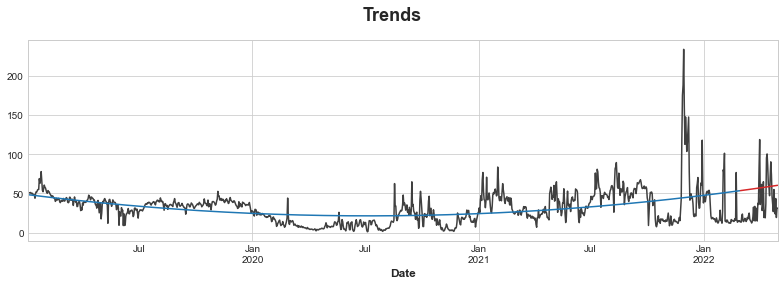

In [12]:
# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=61, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [13]:
X=pd.DataFrame(df.iloc[:,1:])
X['PriceLag']=df.Price.shift(1)
# X["Month"]=[int(datetime.datetime.strptime(str(n), '%Y-%m-%d %H:%M:%S').strftime('%m')) for n in X.index]
X.dropna(inplace=True)

In [14]:
X

,GDP,netimport,EV,EG,carbon,crude,gas,temp,precip,wind,PriceLag
Date,,,,,,,,,,,
2019-01-02,53293.963287,-21.708370,8.036170,165.900397,24.727155,54.910000,2.958000,-1.1,1.081985,17.802005,22.58
2019-01-03,53295.735821,-21.745108,8.042818,165.921191,24.488984,55.950001,2.945000,-2.7,1.050423,17.888769,42.65
2019-01-04,53297.504864,-21.781844,8.049554,165.941983,24.200305,57.060001,3.044000,2.7,1.019531,17.976465,51.90
2019-01-05,53299.270346,-21.818573,8.056381,165.962772,23.858996,57.708959,3.060007,0.8,0.989615,18.065043,50.85
2019-01-06,53301.032199,-21.855295,8.063298,165.983556,23.462935,58.434992,2.979704,0.8,0.960979,18.154456,50.72
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,53256.877019,-23.672716,17.801233,184.189287,83.430000,104.989998,6.850000,7.3,1.156897,21.354969,40.27
2022-04-27,53252.699646,-23.660389,17.636705,184.239084,81.615707,105.320000,7.267000,4.9,1.168487,21.423244,23.94
2022-04-28,53248.495739,-23.648040,17.471570,184.288904,80.550000,107.589996,6.888000,7.0,1.179634,21.488335,43.43


In [15]:
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [16]:
# y_fit = y_fit.stack().squeeze()    # trend from training set
# y_pred = y_pred.stack().squeeze()  # trend from test set
y_resid = y_train - y_fit

In [17]:
# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = (xgb.predict(X_train) + y_fit.T).T
y_pred_boosted = (xgb.predict(X_test) + y_pred.T).T

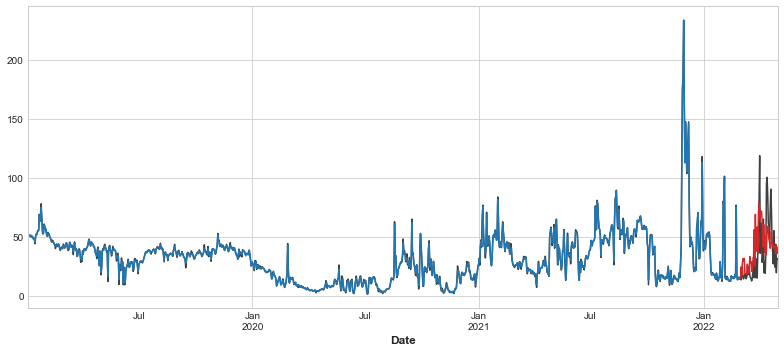

In [18]:
axs = y_train.plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
)
axs = y_test.plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

In [19]:
y_pred_boosted

,Price
Date,
2022-03-01,14.559314
2022-03-02,24.276176
2022-03-03,17.338427
2022-03-04,27.491720
2022-03-05,31.409381
...,...
2022-04-26,39.584394
2022-04-27,35.604883
2022-04-28,42.342672


In [20]:
M=MSE(y_test,y_pred_boosted)
R=R2(y_test,y_pred_boosted)
MA=MAPE(y_test,y_pred_boosted)
print('\nMSE:',M,'\nr2_score:', R,'\nMAPE:', MA,'\n')



MSE: 477.02090738204055 
r2_score: 0.25312205849604485 
MAPE: 0.5800034496756402 

